# What is Faber's trading strategy?

One buys when the monthly price of an asset in our portfolio exceeds its 10-month simple moving average and sells and moves to cash when the same price of that asset drops below its 10-month simple moving average. There is, however, one caveat for every monthly trading period: the total cash spent must not exceed the portfolio's total valuation. This rule is to prevent the algorithm from heavily borrowing to buy more assets. This practice is obviously very risky in practice and leads to overoptimistic results given our backtesting period is only within the past 7 or so years where the market has performed well.

# Reasons for this strategy in particular

Faber claims that a market timing strategy outperforms the market average, as shown by its consistently better performance than a simple buy-and-hold strategy. Furthermore, we can avoid look-ahead bias since our calculations are based solely on the close prices of the last trading day of each month. Then, assuming that the next trading day's price will be relatively similar to the previous day's closing price, we can reliably buy our asset at a price similar to the aforementioned closing price.

Finally, this strategy is very simple, to the point that it may be oversimplistic (we do not account for slippage or transaction costs). We buy a fixed number of shares whenever the monthly price exceeds the 10-month SMA and sell all of our shares of a particular asset when its monthly price is below the 10-month SMA. Therefore, we can confidently say that our model most likely does not suffer from overfitting.

In [1]:
%load_ext zipline

In [9]:
#%load faber.py
import sys
sys.path.append('C:/Users/William/Documents/GitHub/faber-trading-strategy/algos')
from numpy import mean
from collections import defaultdict
from zipline.api import order, record, symbol, date_rules, time_rules, schedule_function
from write_to_sql import run
import pandas as pd
import os
from zipline import run_algorithm

def initialize(context):
    """
    Stores the names of the stocks we'll be looking at.
    
    Input: a persistent namespace where we store an SID/list of SIDs
    
    Output: n/a
    """
    context.benchmark = symbol('SPY')

    context.symbol = [symbol('XLB'),
                      symbol('XLE'),
                      symbol('XLF'), 
                      symbol('XLK'), 
                      symbol('XLP'), 
                      symbol('XLY')]

    # context.benchmark = symbol('GOOG')

    # context.symbol = [symbol('AAPL'),
    #                   symbol('MSFT')]

    # skip the first 300 days of the timeframe so that we have enough data to calculate our 10 month SMA
    context.skip = 0
    context.init = True

    # keep track of number of shares bought
    context.shares = defaultdict(int)
    context.moving_avg = defaultdict(int)
    context.monthly_price = defaultdict(list)

    # skip the first 10 months so that we have enough data to establish our moving average    
    schedule_function(buy_monthly, date_rules.month_end(), time_rules.market_close())

def handle_data(context, data):
    """
    Calls the trading strategy function at the end of every month.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing)
    """
    # context.portfolio.starting_cash = float(100000)
    pass

def buy_monthly(context, data):
    """
    Herein lies Faber's trading strategy.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing) on the last trading day of each month
    """
    # context.portfolio.starting_cash = float(100000)

    context.skip += 1
    money_spent = 0
    value = context.portfolio.portfolio_value

    if context.skip < 10:
        for asset in context.symbol:
            price = data.current(asset, 'price')
            context.monthly_price[asset].append(price)

    else:
        # record benchmark's "first" price
        if context.init == True:
            context.ratio = context.portfolio.portfolio_value / data.current(context.benchmark, 'price')
            context.init = False

        for asset in context.symbol:
            price = data.current(asset, 'price')

            # Get closing price on last trading day of month
            context.monthly_price[asset].append(price)

            # calculate the 10-month moving average of each asset
            context.moving_avg[asset] = mean(context.monthly_price[asset][context.skip - 9: context.skip])
        
        ### Faber's trading strategy ###
        
        # if the current price exceeds moving average, long
        for asset in context.symbol:
            # the most current monthly price will be the one added most recently (so it'll be the element on the end of the list)
            if context.monthly_price[asset][-1] > context.moving_avg[asset] and money_spent < value:
                order(asset, 500)
                context.shares[asset] += 500

                # add amount ordered to total money spent during this specific buying period
                money_spent += 500 * data.current(asset, 'price')

            # else if the current price is below moving average, short
            elif context.monthly_price[asset][-1] < context.moving_avg[asset]:
                order(asset, -context.shares[asset])
                context.shares[asset] = 0

                money_spent -= 500 * data.current(asset, 'price')

            # save/record the data for future plotting
            # record(asset = context.monthly_price[asset][-1], sma = context.moving_avg[asset])

        # record portfolio value
        record(portfolio = context.portfolio.portfolio_value)

        # also record the S&P 500 monthly price
        record(SPY = context.ratio * data.current(context.benchmark, 'price'))
     
def analyze(context = None, results = None):
    """
    Plots the results of the strategy against a buy-and-hold strategy.
    
    Input: n/a?
    
    Output: a plot of two superimposed curves, one being Faber's strategy and the other being a buy-and-hold strategy.
    """
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax1 = fig.add_subplot(211)

    # plot both the portfolio based on faber's strategy and a buy-and-hold strategy
    results['portfolio'].plot(ax=ax1)
    results['SPY'].plot(ax=ax1)

    ax1.set_ylabel('Portfolio value (USD)')

    plt.show()

    tickers = []
    for symbol in context.symbol:
        symbol = str(symbol).translate(None, '0123456789[]() ')[6:]
        tickers.append(symbol)

#     run('test.db', results, 'faber', tickers)
 

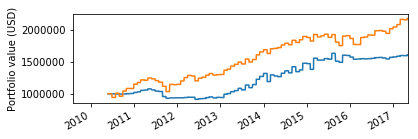

,SPY,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2009-08-03 20:00:00+00:00,NaN,NaN,0.000000,NaN,0.016496,NaN,NaN,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,1,[],0.0366
2009-08-04 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.019128,0.156113,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,2,[],0.0370
2009-08-05 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.016193,0.158581,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,3,[],0.0380
2009-08-06 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.010930,0.154331,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,4,[],0.0379
2009-08-07 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.024188,0.152547,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,5,[],0.0389
2009-08-10 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.022063,0.143590,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,6,[],0.0380
2009-08-11 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,1.469284,8.474839,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,7,[],0.0371
2009-08-12 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.020140,9.018672,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,8,[],0.0372
2009-08-13 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.027932,8.452366,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,9,[],0.0359
2009-08-14 20:00:00+00:00,NaN,0.000000,0.000000,0.000000,0.020038,7.985757,0.000000,0.000000,1000000.000000,0.000,...,0,0,0,NaN,1000000.000000,0.000,0.000,10,[],0.0355


In [10]:
%zipline --start 2009-8-1 --end 2017-5-1 -b faber-bundle --capital-base 1000000